# The Battle of Neighborhoods
## Opening Turkish Restaurants in Bucharest, Romania

## Introduction
In this project, I will determine which place is good for opening a Turkish restaurant in Bucharest, Romania.
- I will convert address data into their equivalent latitude and longitude values.
- For Bucharest neighborhood data, I will use Wikipedia.
- I will use the Foursquare API to explore Sacramento neighborhoods and to get venues in neigborhoods.
- I will use the Foursquare API to get venue ratings and likes in neighborhoods.
- I will use the k-means clustering and Agglomerative algorithms to complete clustering task.
- I will use the Folium library to visualize the neighborhoods, venues, clusters in Bucharest.

## Table of Contents
1. Download and explore neighborhood dataset
2. Load and analyze venues of neighborhoods in Bucharest
3. Cluster neighborhoods using Agglomerative Clustering
4. Discussion
5. Conclusion

## Download and Explore Neighborhood Dataset

### Import Libraries

In [1]:
!pip install geopy    
!pip install folium   
!pip install geocoder

     |████████████████████████████████| 102kB 9.9MB/s eta 0:00:01
     |████████████████████████████████| 102kB 10.1MB/s ta 0:00:01


In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt

import json

from geopy.geocoders import Nominatim
import geocoder

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium
from folium import plugins
from folium.plugins import HeatMap

from bs4 import BeautifulSoup 
import requests

print('Libraries imported.')

Libraries imported.


In [3]:
bucharest_address = 'Bucharest, Romania'
geolocator = Nominatim(user_agent = 'bucharest_explorer')
location = geolocator.geocode(bucharest_address)
latitude = location.latitude
longitude = location.longitude
sacramento_center = [latitude, longitude]
print('The geographical coordinates of {} are {}, {}.'.format(bucharest_address, latitude, longitude))

The geographical coordinates of Bucharest, Romania are 44.4361414, 26.1027202.


### Get Neighborhood Data of Bucharest

In [4]:
url = 'https://en.wikipedia.org/wiki/Category:Districts of Bucharest'
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

neighborhoodList = []

for row in soup.find_all('div', class_='mw-category')[0].findAll('li'):
    neighborhoodList.append(row.text.replace(', Bucharest',''))
    
df_neighborhood = pd.DataFrame({'Neighborhood': neighborhoodList})
print('There are {} neighborhoods in {}'.format(df_neighborhood.shape[0], bucharest_address))

There are 40 neighborhoods in Bucharest, Romania


In [6]:
url = "https://en.wikipedia.org/wiki/Sectors of Bucharest"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

sectorPopList = []
sectorPopulationList = []

for row in soup.find_all("tbody"):
    header = str(row.findAll("th"))
    if "Population (October 2011)" in header:
        i = 0
        for td in row.find_all("td"):
            i+=1
            if i==2: 
                sectorPopList.append(td.text.replace("\n",""))
            if i==3: 
                sectorPopulationList.append(td.text.replace("\n",""))    
                i=0

df_sectorPop = pd.DataFrame({"Sector": sectorPopList, "Population": sectorPopulationList})

sectorNeigList =[]
sectorNeigborList =[]

for row in soup.find_all("ul"):
    if sectorPopList[0] in  row.text:
        for s in row.text.split("\n"):
            sectorNeigList.append(s.split(":")[0])
            sectorNeigborList.append(s.split(":")[1])
    
df_sector= pd.DataFrame({"Sector": sectorNeigList, "Neigborhoods": sectorNeigborList}).merge(df_sectorPop,on='Sector' )

print("There are {} sectors in {}".format(df_sector.shape[0], bucharest_address))
df_sector

There are 6 sectors in Bucharest, Romania


,Sector,Neigborhoods,Population
0,Sector 1,"Dorobanți, Băneasa, Aviației, Pipera, Aviator...","225,454"
1,Sector 2,"Pantelimon, Colentina, Iancului, Tei, Floreas...","345,370"
2,Sector 3,"Vitan, Dudești, Titan, Centrul Civic, Balta A...","385,439"
3,Sector 4,"Berceni, Olteniței, Văcărești, Timpuri Noi, T...","287,828"
4,Sector 5,"Rahova, Ferentari, Giurgiului, Cotroceni, 13 ...","271,575"
5,Sector 6,"Giulești, Crângași, Drumul Taberei, Militari,...","367,760"


In [9]:
def getSector(row):
    for i in range(df_sector.shape[0]):
        if row["Neighborhood"] in  df_sector.iloc[i].Neigborhoods:
            return pd.Series([df_sector.iloc[i].Sector, df_sector.iloc[i].Population], index = ['Sector','SectorPopulation'])

df_neighborhood[["Sector","SectorPopulation"]] =df_neighborhood.apply(getSector, axis=1)
df_neighborhood.head(5)

,Neighborhood,Sector,SectorPopulation
0,Aviației,Sector 1,"225,454"
1,Băneasa,Sector 1,"225,454"
2,Berceni,Sector 4,"287,828"
3,Bucureștii Noi,Sector 1,"225,454"
4,Centrul Civic,Sector 3,"385,439"


In [10]:
def get_latlng(neighborhood):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(neighborhood,bucharest_address))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [ get_latlng(neighborhood) for neighborhood in df_neighborhood["Neighborhood"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

df_neighborhood['Latitude'] = df_coords['Latitude']
df_neighborhood['Longitude'] = df_coords['Longitude']
print("Geographical coordinates of five neighborhoods are as below")
df_neighborhood.head()

Geographical coordinates of five neighborhoods are as below


,Neighborhood,Sector,SectorPopulation,Latitude,Longitude
0,Aviației,Sector 1,"225,454",44.485790,26.101220
1,Băneasa,Sector 1,"225,454",44.494010,26.080372
2,Berceni,Sector 4,"287,828",44.386200,26.128960
3,Bucureștii Noi,Sector 1,"225,454",44.484495,26.039608
4,Centrul Civic,Sector 3,"385,439",44.434300,26.094660


In [13]:
map_buc = folium.Map(location = [latitude, longitude], zoom_start = 11)
for lat, lng, neighborhood in zip(df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue', 
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html=False).add_to(map_buc)
map_buc

## Load Venues and Analyze Neighborhoods in Bucharest

We will use Foursquare API for getting venues of neighborhoods

### Explore Venues of Bucharest Neighborhoods

I get a venue list with 1 km distance to neighborhood's center

In [16]:
LIMIT = 100
CLIENT_ID = 'BDKYUUHRDFEVFXWNUDYZ5EL2CBEXCPKVZFZVNLXALYK31YAI'
CLIENT_SECRET = '5V1KFFPV22UUG4J0O5CBSEXWQ10TCMWY0JGKXCGWAP45X2HA'
VERSION = '20180604'
def getNeighborhoodVenues( latitude, longitude,neighborhood, radius=1000 ):
    venues = []
    for lat, long, neighborhood in zip(latitude, longitude ,neighborhood):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            long,
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        for venue in results:
            venues.append((
                neighborhood,
                lat, 
                long, 
                venue['venue']['name'], 
                venue['venue']['id'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['location']['distance'],  
                venue['venue']['categories'][0]['name']))
    
    # convert the venues list into a DataFrame
    venues = pd.DataFrame(venues)
    # define the column names
    venues.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
            
    return venues 

neighborhood_venues = getNeighborhoodVenues (df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood'] )

print('There are {} unique venue categories. Some of them are as below:'.format(len(neighborhood_venues['VenueCategory'].unique())))
neighborhood_venues.head()

There are 229 unique venue categories. Some of them are as below:


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,Aviației,44.48579,26.10122,LIDL,583956246d349d0574eb02ac,44.488396,26.094375,616,Supermarket
1,Aviației,44.48579,26.10122,ibis Styles Bucharest Erbas,5bbb782175dcb7002cc15ee7,44.483963,26.097134,382,Hotel
2,Aviației,44.48579,26.10122,Mega Image Concept Store,56348b62498e53f51a0a4e0e,44.479783,26.102568,677,Supermarket
3,Aviației,44.48579,26.10122,ORYGYNS Specialty Coffee,5807575ed67ca95d8cf5ccb9,44.480010,26.100450,646,Coffee Shop
4,Aviației,44.48579,26.10122,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,716,Burger Joint


In [15]:
print('Top 10 distinct venue counts are as below: ')
neighborhood_venues[['VenueId', 'VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['VenueId']].rename(columns = {'VenueId': 'Count'}).sort_values(by = ['Count'], ascending=False)[:10]

Top 10 distinct venue counts are as below: 


,Count
VenueCategory,
Restaurant,67
Italian Restaurant,62
Café,62
Coffee Shop,60
Supermarket,58
Pizza Place,45
Gym,45
Romanian Restaurant,42
Hotel,41


In [17]:
restaurant_list =['Restaurant', 'Burger Joint','Café','Fried Chicken Joint','Pizza Place']
turkish_restaurant_list = ['Turkish Restaurant', 'Doner Restaurant']

# Filter restaurants 
    
neighborhood_venues['RestFlag']=False
for restCat in restaurant_list:
    neighborhood_venues['RestFlag'] = neighborhood_venues['RestFlag'] | neighborhood_venues['VenueCategory'].str.contains(restCat)
    
neighborhood_restaurants = neighborhood_venues[neighborhood_venues['RestFlag'] == True].iloc[:,:-1]
turkish_restaurants = neighborhood_restaurants[ neighborhood_restaurants['VenueCategory'].isin(turkish_restaurant_list) ]
other_restaurants = neighborhood_restaurants[ ~neighborhood_restaurants['VenueCategory'].isin(turkish_restaurant_list) ]

print('Total number of restaurants:', len(neighborhood_restaurants['VenueId'].unique()))
print('Total number of Turkish restaurants:', len(turkish_restaurants['VenueId'].unique()))
print('Percentage of Turkish restaurants: {:.2f}%'.format(len(turkish_restaurants['VenueId'].unique()) / len(neighborhood_restaurants['VenueId'].unique()) * 100))

Total number of restaurants: 494
Total number of Turkish restaurants: 21
Percentage of Turkish restaurants: 4.25%


20 neighborhoods do not have any Turkish restaurant


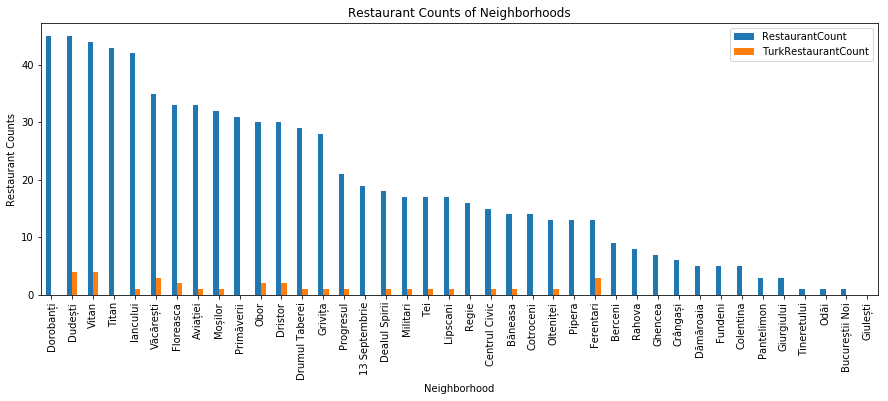

In [18]:
# get counts of restaurants in each Neighborhood
df_rest_counts =  neighborhood_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "RestaurantCount"})[['RestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(neighborhood_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_rest_counts = df_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'RestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_rest_counts.reset_index(inplace=True)

#####
# get counts of Turkish restaurants in each Neighborhood
df_turk_rest_counts =  turkish_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "TurkRestaurantCount"})[['TurkRestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(turkish_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_turk_rest_counts = df_turk_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'TurkRestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_turk_rest_counts.reset_index(inplace=True)
df_rest_counts= df_rest_counts.merge(df_turk_rest_counts).set_index('Neighborhood')
df_rest_counts= df_rest_counts.sort_values(by=['RestaurantCount'],ascending =False)

print('{} neighborhoods do not have any Turkish restaurant'.format(len(noRestList)))
######
#Draw graph
df_rest_counts[['RestaurantCount','TurkRestaurantCount']].plot(kind='bar',figsize=(15,5))
plt.title('Restaurant Counts of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Restaurant Counts')
plt.show()

We can draw the following conclusion based on the graph:
- Vitan is the neihgborhood having most restaurants.
- Dorobanti is has lots of restaurants , but no Tukish restaurant.
- Odai and Gluesti are neihgborhoods having least number of restaurants.
- 19 neighborhoods do not have any Turkish restaurant. we can choose one of these to open resaturant. To filter more let's continue.

### Get the restaurant's overall rating

I used Foursquare API to get likes and ratings of restaurants

In [19]:
def getVenueRaitings(venues):
    
    raitings = []
    likes =[]
    for venueId in venues:

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueId, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        try:
            rating = result['response']['venue']['rating']
            likes = result['response']['venue']['likes']['count']
        except:
            rating = None
            likes = None
        
        raitings.append((venueId, rating,likes))
 
    # convert the venues list into a DataFrame
    rating = pd.DataFrame(raitings)
    # define the column names
    rating.columns = ['VenueId', 'VenueRating','VenueLikes']

    return rating    

restaurants_raitings = getVenueRaitings(neighborhood_restaurants['VenueId'].drop_duplicates())
restaurants_raitings.head()

,VenueId,VenueRating,VenueLikes
0,58a2fc95d0bb3e516a2363b7,8.2,22.0
1,55b8a459498efbbb6ca3526d,8.2,9.0
2,53623e44498ed583ede334f5,8.0,130.0
3,58bbf8764f1069627380fed5,7.6,22.0
4,59ee47be0d8a0f244d41fca7,7.5,9.0


In [20]:
neighborhood_restaurants = neighborhood_restaurants.merge(restaurants_raitings)
neighborhood_restaurants.head()

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Aviației,44.48579,26.101220,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,716,Burger Joint,8.2,22.0
1,Floreasca,44.47633,26.103279,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,349,Burger Joint,8.2,22.0
2,Aviației,44.48579,26.101220,Toàn's,55b8a459498efbbb6ca3526d,44.478370,26.103411,844,Vietnamese Restaurant,8.2,9.0
3,Floreasca,44.47633,26.103279,Toàn's,55b8a459498efbbb6ca3526d,44.478370,26.103411,227,Vietnamese Restaurant,8.2,9.0
4,Aviației,44.48579,26.101220,trickSHOT,53623e44498ed583ede334f5,44.478378,26.103135,838,Restaurant,8.0,130.0


In [21]:
turkish_restaurants = turkish_restaurants.merge(restaurants_raitings)
turkish_restaurants.head(5)

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Aviației,44.485790,26.101220,Istanbul Taksim,55acc94f498e0a64af6b19af,44.478560,26.103505,825,Turkish Restaurant,7.0,11.0
1,Floreasca,44.476330,26.103279,Istanbul Taksim,55acc94f498e0a64af6b19af,44.478560,26.103505,248,Turkish Restaurant,7.0,11.0
2,Băneasa,44.494010,26.080372,Shaormeria Băneasa,5137a298e4b0523475c45b54,44.494460,26.080462,50,Doner Restaurant,7.3,40.0
3,Centrul Civic,44.434300,26.094660,Dristor Kebap,4dc58dd7887717c8802694a1,44.430054,26.100384,656,Doner Restaurant,NaN,NaN
4,Lipscani,44.431885,26.100915,Dristor Kebap,4dc58dd7887717c8802694a1,44.430054,26.100384,208,Doner Restaurant,NaN,NaN


### Show restaurants on head map

Let's create a heatmap, showing density of restaurants and try to extract some meaningful information from the heatmap. Show the borders of Bucharest on our map and a few circles of distane 2km, 4km, 6km, and 10km from Bucharest's center.
Let red markets be Turkish restaurants.
Let blue markers be Turkish restaurants with less than 7 restaurants rated.

In [24]:
bucharest_center = [latitude, longitude]
map_restaurant= folium.Map(location=bucharest_center, zoom_start=12)
df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_buc) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_buc)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig, name in zip(turkish_restaurants['VenueLatitude'], turkish_restaurants['VenueLongitude'], turkish_restaurants['Neighborhood'], turkish_restaurants['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)
       
raiting_lt_7 = turkish_restaurants[turkish_restaurants['VenueRating'] <7]
for lat, lon, neig, name in zip(raiting_lt_7['VenueLatitude'], raiting_lt_7['VenueLongitude'], raiting_lt_7['Neighborhood'], raiting_lt_7['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)        
map_restaurant

Based on the heatmap, we can draw the following conclusions:
- There are too many restaurants within 4km of the center.
- There are enough restaurants within 4km-6km of the center.
- There are not that many resturants within 6km-10km of the center.
- Turkish restaurants are superimposed with red and blue dots. Blue dots are Turkish restaurants with a rating of less than 7.
- Turkish restaurants are located South, North, and East, between 2km-4km around the center.
- There are no Turkish restaurants in West Bucharest.
- Only 3 Turkish restaurants get bad ratings.

### Show neighborhoods with no Turkish restaurants on a heat map

Cyan markers are neighborhoods without any Turkish restaurants.

In [27]:
bucharest_center = [latitude, longitude]
map_restaurant= folium.Map(location=bucharest_center, zoom_start=12)

df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_buc) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_buc)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig in zip(df_neighborhood_noturkrest['Latitude'], df_neighborhood_noturkrest['Longitude'], df_neighborhood_noturkrest['Neighborhood']):
    label = folium.Popup(str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7).add_to(map_restaurant)
map_restaurant

## 3. Cluster Neighborhoods using Agglomerative Clustering

In [28]:
# one hot encoding
onehot = pd.get_dummies(neighborhood_venues[['VenueCategory']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
onehot['Neighborhood'] = neighborhood_venues['Neighborhood']

venues_grouped = onehot.groupby(["Neighborhood"]).sum().reset_index()

# move neighborhood column to the first column and filter only restaurant columns 
fixed_columns =['Neighborhood'] + list(neighborhood_venues['VenueCategory'].unique())
venues_grouped = venues_grouped[fixed_columns]

print("{}  neighborhoods' venue category are shown in {} columns as below".format(venues_grouped.shape[0],venues_grouped.shape[1]-1))
venues_grouped.head()

40  neighborhoods' venue category are shown in 229 columns as below


,Neighborhood,Supermarket,Hotel,Coffee Shop,Burger Joint,Dessert Shop,Roof Deck,Grocery Store,Vietnamese Restaurant,Beer Garden,Restaurant,Bookstore,Gym / Fitness Center,Salad Place,Salon / Barbershop,Shopping Mall,Pie Shop,Café,Steakhouse,Sushi Restaurant,Lebanese Restaurant,Italian Restaurant,Clothing Store,Toy / Game Store,Turkish Restaurant,Bakery,Sandwich Place,Casino,Spanish Restaurant,Pizza Place,Middle Eastern Restaurant,Event Space,Indoor Play Area,Lounge,Eastern European Restaurant,Fried Chicken Joint,Stadium,Snack Place,Tennis Stadium,Mongolian Restaurant,Romanian Restaurant,Men's Store,Cocktail Bar,Donut Shop,Gym,Doner Restaurant,Vegetarian / Vegan Restaurant,Lake,Park,Nightclub,Tunnel,Theme Restaurant,Farmers Market,Bed & Breakfast,Bus Station,Airport Terminal,Athletics & Sports,Nature Preserve,Fast Food Restaurant,Electronics Store,Jewelry Store,Metro Station,Fountain,Pharmacy,Gas Station,Light Rail Station,Gym Pool,Cupcake Shop,Theater,Department Store,Gastropub,Bistro,Indie Theater,Outdoor Sculpture,Monastery,Skating Rink,Ice Cream Shop,Used Bookstore,Chocolate Shop,Art Museum,Historic Site,Tea Room,Plaza,Music Store,Bar,Concert Hall,Wine Bar,Cosmetics Shop,Rock Club,Palace,History Museum,Beer Bar,Swiss Restaurant,Hostel,Art Gallery,Church,Hardware Store,Discount Store,Antique Shop,Arts & Crafts Store,Auto Dealership,Herbs & Spices Store,Furniture / Home Store,Gift Shop,Tennis Court,Jazz Club,Accessories Store,Market,Opera House,Pedestrian Plaza,Hotel Bar,Spa,Garden,Pub,Indian Restaurant,Pool,Indie Movie Theater,Australian Restaurant,Shoe Store,Food & Drink Shop,French Restaurant,Climbing Gym,Soccer Stadium,Miscellaneous Shop,Laundromat,Convenience Store,Outlet Mall,Women's Store,Mexican Restaurant,Flower Shop,Japanese Restaurant,Fish Market,Scandinavian Restaurant,Juice Bar,Cheese Shop,Asian Restaurant,Mediterranean Restaurant,Seafood Restaurant,Fruit & Vegetable Store,Modern European Restaurant,German Restaurant,Molecular Gastronomy Restaurant,Wine Shop,Hookah Bar,American Restaurant,Drugstore,Auto Workshop,Pet Store,Multiplex,Eye Doctor,Chinese Restaurant,Skate Park,Greek Restaurant,Construction & Landscaping,Water Park,Brewery,Food Court,Mobile Phone Shop,Diner,Veterinarian,Health Food Store,Portuguese Restaurant,Science Museum,Lingerie Store,Cable Car,Tram Station,Boxing Gym,Soccer Field,Bagel Shop,Museum,Health & Beauty Service,Food Truck,Buffet,Movie Theater,Paper / Office Supplies Store,Kebab Restaurant,Exhibit,Public Art,Pool Hall,Music Venue,Tattoo Parlor,Sporting Goods Shop,Gourmet Shop,Hospital,Falafel Restaurant,Cultural Center,Football Stadium,Intersection,BBQ Joint,Big Box Store,Hungarian Restaurant,Karaoke Bar,Optical Shop,Beach,Auto Garage,Theme Park,Martial Arts Dojo,Basketball Court,Laser Tag,Shop & Service,Bowling Alley,Sports Club,Train Station,Go Kart Track,IT Services,Track,Bike Shop,Recreation Center,Creperie,Playground,Bike Rental / Bike Share,Korean Restaurant,Dog Run,Sports Bar,Business Service,Lighting Store,Comfort Food Restaurant,Taco Place,Boutique,Fish & Chips Shop,Recording Studio,Smoke Shop,ATM,Soup Place,Circus,Dance Studio,Pet Café,Leather Goods Store,Gaming Cafe,Camera Store
0,13 Septembrie,1,3,2,0,1,0,0,0,0,5,0,2,0,0,0,0,3,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,2,0,1,0,0,0,0,2,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,2,4,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,1,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,1,0,0,0,0,0,0,0,0,0
1,Aviației,4,4,4,3,2,1,1,1,1,7,1,2,1,1,1,1,6,3,2,2,1,3,1,1,3,1,1,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [29]:
# create a new dataframe with most common venue catrgories
def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

columns = ['Neighborhood','Total Number of Venues']
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
venues_most = pd.DataFrame(columns = columns)

for ind in range(venues_grouped.shape[0]):
    venues_most.loc[ind, 'Neighborhood'] = venues_grouped.iloc[ind].Neighborhood
    venues_most.loc[ind, 'Total Number of Venues'] = venues_grouped.iloc[ind,1:].sum()
    venues_most.iloc[ind, 2:] = return_most_common_venues(venues_grouped.iloc[ind, 1:], num_top_venues)

venues_most.head()

,Neighborhood,Total Number of Venues,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,13 Septembrie,64,Restaurant,Plaza,Hotel,Café,Pub,Lounge,Tea Room,Comfort Food Restaurant,Seafood Restaurant,Gym / Fitness Center
1,Aviației,79,Restaurant,Café,Pizza Place,Supermarket,Coffee Shop,Hotel,Burger Joint,Bakery,Steakhouse,Clothing Store
2,Berceni,25,Pizza Place,Grocery Store,Gym / Fitness Center,Romanian Restaurant,Supermarket,Lebanese Restaurant,Fountain,Metro Station,Jewelry Store,Electronics Store
3,Bucureștii Noi,17,Supermarket,Park,Grocery Store,Farmers Market,Gym,Department Store,Theater,Cupcake Shop,Restaurant,Gym Pool
4,Băneasa,31,Restaurant,Hotel,Italian Restaurant,Romanian Restaurant,Gym,Farmers Market,Theme Restaurant,Tunnel,Nightclub,Sandwich Place


### Cluster and find similarities between neighborhoods

I will use the heirarchical agglomerative clustering method to compare neighborhoods among neighborhoods.
First, find the number of clusters by using scipy library to create the dendogram for our dataset.

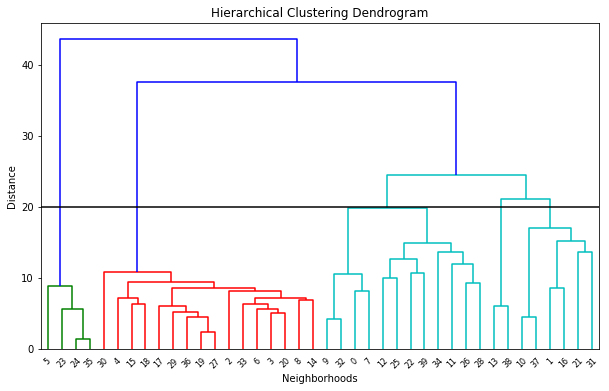

In [30]:
import scipy.cluster.hierarchy as shc

data = venues_grouped.iloc[:,3:]
plt.figure(figsize=(10, 6))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
plt.axhline(y=20, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))

Based on the above graph, it let me separate our the neighborhoods into 6 unique clusters (with the cutoff distance at 20, noted as horizontal black line). I will use the hierarchical agglomerative clustering from sklearn.cluster library to cluster these neighborhoods.

In [32]:
from sklearn.cluster import AgglomerativeClustering

kclusters= 6
cluster = AgglomerativeClustering(n_clusters=kclusters, affinity='euclidean', linkage='ward')  
clusterresult = cluster.fit_predict(data)

venues_grouped['NeighborhoodCluster'] = clusterresult
venues_cluster= df_neighborhood.merge(venues_grouped[['Neighborhood','NeighborhoodCluster']])
venues_cluster =venues_cluster.merge(venues_most[['Neighborhood','1st Most Common Restaurant','2nd Most Common Restaurant','3rd Most Common Restaurant']])
venues_cluster.head()

,Neighborhood,Sector,SectorPopulation,Latitude,Longitude,NeighborhoodCluster,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant
0,Aviației,Sector 1,"225,454",44.485790,26.101220,0,Restaurant,Café,Pizza Place
1,Băneasa,Sector 1,"225,454",44.494010,26.080372,2,Restaurant,Hotel,Italian Restaurant
2,Berceni,Sector 4,"287,828",44.386200,26.128960,2,Pizza Place,Grocery Store,Gym / Fitness Center
3,Bucureștii Noi,Sector 1,"225,454",44.484495,26.039608,2,Supermarket,Park,Grocery Store
4,Centrul Civic,Sector 3,"385,439",44.434300,26.094660,3,Coffee Shop,Hotel,Theater


In [33]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster, sector,SectorPopulation  in zip(venues_cluster['Latitude'], venues_cluster['Longitude'], venues_cluster['Neighborhood'], venues_cluster['NeighborhoodCluster'], venues_cluster['Sector'],venues_cluster['SectorPopulation']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster)+ ' ' + str(sector) + ' ' + str(SectorPopulation), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
folium.Marker(bucharest_center).add_to(map_clusters)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_clusters)         
map_clusters

In [34]:

print(venues_cluster.groupby(['NeighborhoodCluster','1st Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"}))

venues_cluster.groupby(['NeighborhoodCluster','2nd Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"})

                                                Neighborhood Count
NeighborhoodCluster 1st Most Common Restaurant                    
0                   Café                                         2
                    Coffee Shop                                  3
                    Restaurant                                   1
1                   Italian Restaurant                           4
                    Pizza Place                                  1
                    Pub                                          1
                    Supermarket                                  2
2                   Furniture / Home Store                       1
                    Grocery Store                                1
                    Metro Station                                1
                    Museum                                       1
                    Pharmacy                                     1
                    Pizza Place                               

Neighborhood Count
NeighborhoodCluster 2nd Most Common Restaurant                    
0                   Café                                         1
                    Coffee Shop                                  2
                    Gym / Fitness Center                         1
                    Italian Restaurant                           1
                    Pub                                          1
1                   Café                                         2
                    Gym                                          3
                    Italian Restaurant                           2
                    Supermarket                                  1
2                   Arts & Crafts Store                          1
                    Athletics & Sports                           1
                    Auto Garage                                  1
                    Burger Joint                                 1
                    Café                                         1
                    Fast Food Restaurant                         1
                    Grocery Store                                1
                    Gym                                          1
                    Health & Beauty Service                      1
                    Hotel                                        1
                    Italian Restaurant                           1
                    Park                                         1
                    Pedestrian Plaza                             1
                    Salon / Barbershop                           1
                    Soccer Field                                 1
                    Supermarket                                  1
3                   Hotel                                        4
4                   Lounge                                       1
                    Supermarket                                  1
5                   Bistro                                       1
                    Bus Station                                  1
                    Plaza                                        1
                    Supermarket                                  1

#### We can see cluster categories as below
Cluster 0 (Red): Café, Italian Restaurant, Pub <br>
Cluster 1 (Purple): Café, Pub <br>
Cluster 2 (Blue): Grocery Store, Plaza <br>
Cluster 3 (Cyan): Café, Hotel <br>
Cluster 4 (Green): Café, Lounge <br>
Cluster 5 (Orange): Plaza, Bistro, Supermarket <br>

### 4. Discussion

Cluster 2 suffers from a lack of restaurants. We can think about adding a Turkish restaurant in Cluster 2, in particular on the West side Bucharest. <br>
Cluster 0 has a preference for Italian restaurants, suggesting that Turkish restaurants would not be successful in Cluster 0, with the except of one location, which might work. <br>
Cluster 1, 2, and 3 are full of restaurants, as shown with the heatmap. <br>

### 5. Conclusion

There are a few neighborhoods with potential of opening a successful Turkish restaurant: <br>
- Neighborhood: Regie, Cluster 1, Sector 6, Population: 367760 <br>
    I chose Regie, since the west part of Bucharest has no Turkish restaurants and Regie is also very close to the center. Regies is also in a Cluster that seems to be open to a variety of kinds of restaurants.
- Neighborhood: Bucureștii Noi , Cluster 2, Sector 1 , Population : 225454 <br>
    I chose Bucureștii Noi becuase, like Regie, it is in the west part of Bucharest which has no Turkish restaurants. Considering the lack of restaurants 6km from the center, this is a good option to open one in this area.
- Neighborhood: Crângași, Cluster 2, Sector 6 , Population : 367760 <br>
    I chose Crângași because like Bucureștii Noi and Regie, it is in the west part of Bucharest which has no Turkish restaurants. I chose this Sector specifically because of the large population. Wiht a large population, it can support multiple restaurants and a diverse choice of restaurants is a great business practice.
- Neighborhood: Tineretului, Cluster 2 Sector 4 Population: 287828 <br>
    I chose Tineretului because it is very isolated and it has no Turkish restaurants. Because of its isolated nature, this neighborhood does not have many restaurants and it should open a Turkish restaurant.